In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import markov_sim as markov
import json
import os
from datetime import datetime
from dateutil import  parser
from hampel import hampel
import preprocessing as p

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


In [38]:
file = '1.145385390.json'

for line in open(file, 'r'):
    data_list.append(json.loads(line))

with open(file, 'r') as f:
    top = f.readline()
    top = json.loads(top)

runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df = df.resample('1000ms').last()
    print(df)
    return df

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(60, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _1000ms = df.index.floor('1000ms')
    idx_back = df.groupby(_1000ms)['back'].idxmin()
    idx_lay = df.groupby(_1000ms)['lay'].idxmax()
    print(idx_back)
    df = df.resample('1000ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df = df.rolling('60S').mean()
    df = df.loc[start:end]
    df['back-lay avg'] = df[['back', 'lay']].mean(axis=1)
    df['spread'] = df['back'] - df['lay']
    df['vol diff'] = df['back_vol'] - df['lay_vol']
    df['uncertainty'] = df['spread'] / df['back-lay avg']
    df_pup = df['back_vol'] / ( df['back_vol'] + df['lay_vol'] )
    df_pup.name = 'pup'
    df = pd.concat([df, df_pup], axis=1)
    df.fillna(method='ffill', inplace=True)

    return df

def get_weighted_firstserve(r1_firstserve, r2_firstserve):
    total = 1.29
    r1_ratio = r1_firstserve / (r1_firstserve + r2_firstserve)
    r1 = r1_ratio * total
    r2 = total - r1
    return r1, r2

def get_score_time_series(r1_firstserve, r2_firstserve, df_odds):

    setscore = '0-0'
    gamescore = '0-0'

    p, q = get_weighted_firstserve(r1_firstserve, r2_firstserve)
    print(p, q)
    r1_gamescore = []
    r1_setscore = []
    r2_gamescore = []
    r2_setscore = []

    odds_arr = df_odds.to_numpy()

    for odds in odds_arr:
        setscore, gamescore = calc_score(p, q, setscore, gamescore, odds)
        r1_gamescore.append(gamescore.split('-')[0])
        r2_gamescore.append(gamescore.split('-')[1])
        r1_setscore.append(setscore.split('-')[0])
        r2_setscore.append(setscore.split('-')[1])
        if r1_setscore[-1] or r2_setscore[-1] == 3:
            break

    df = pd.DataFrame({'r1_gs': r1_gamescore, 'r2_gs': r2_gamescore, 'r1_setscore': r1_setscore, 'r2_setscore': r2_setscore}, index=df_odds.index)

    return df


def calc_score(p, q, setscore, gamescore, implied_odds):
    nextsetv1 = markov.set_nextscore(gamescore, 1)
    nextsetv2 = markov.set_nextscore(gamescore, -1)
    nextmatchv1 = markov.match_nextscore(setscore, 1)
    nextmatchv2 = markov.match_nextscore(setscore, -1)

    if nextsetv1 is 'SETv1' and nextsetv2 is 'SETv2':
        nextsetv1 = '0-0'
        nextsetv2 = '0-0'
    elif nextsetv1 is 'SETv1':
        nextsetv1 = '0-0'
        nextmatchv2 = setscore
    elif nextsetv2 is 'SETv2':
        nextsetv1 = '0-0'
        nextmatchv1 = setscore
    else:
        nextmatchv1 = setscore
        nextmatchv2 = setscore

    print(p, q)
    print(nextsetv2)
    print(nextmatchv2)
    m1 = markov.tennis_model(p, q, nextmatchv1, nextsetv1, markov.match_initial_state, markov.set_initial_sate, markov.game_initial_state, markov.tb_initial_state)
    m2 = markov.tennis_model(p, q, nextmatchv2, nextsetv2, markov.match_initial_state, markov.set_initial_sate, markov.game_initial_state, markov.tb_initial_state)

    # print(m1)
    # print(m2)

    if implied_odds > m1['r1_win'].values:
        gamescore = nextsetv1
        setscore = nextmatchv1
    elif implied_odds < m2['r1_win'].values:
        gamescore = nextsetv1
        setscore = nextmatchv2

    return setscore, gamescore



<>:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:247: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:247: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_12820/2272636014.py:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if nextsetv1 is 'SETv1' and nextsetv2 is 'SETv2':
/tmp/ipykernel_12820/2272636014.py:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if nextsetv1 is 'SETv1' and nextsetv2 is 'SETv2':
/tmp/ipykernel_12820/2272636014.py:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif nextsetv1 is 'SETv1':
/tmp/ipykernel_12820/2272636014.py:247: SyntaxWarning: "is" with a literal. Di

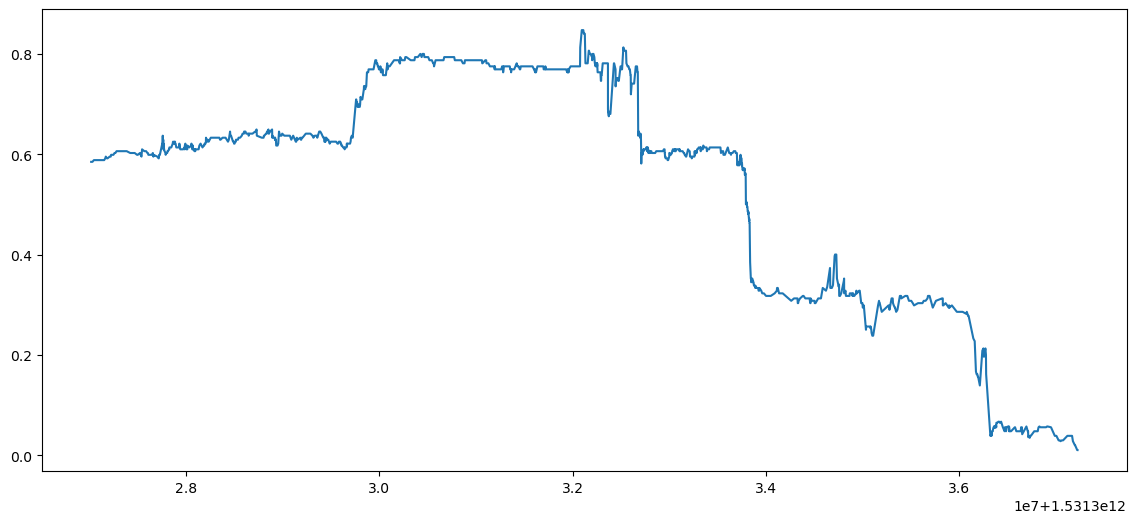

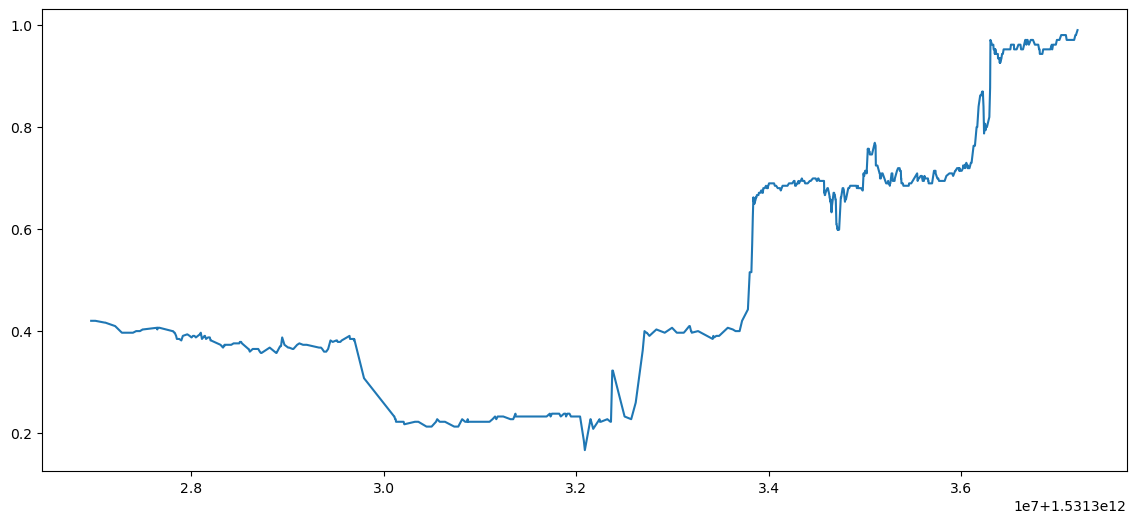

In [10]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [11]:
df = odds_avg(runner_odds_1, runner_odds_2)

                     runner 1  1 - runner 2       avg
2018-07-11 16:36:43  0.584795      0.579832  0.582314
2018-07-11 16:36:44  0.584795      0.579868  0.582332
2018-07-11 16:36:45  0.584795      0.579905  0.582350
2018-07-11 16:36:46  0.584795      0.579942  0.582368
2018-07-11 16:36:47  0.584795      0.579978  0.582387
...                       ...           ...       ...
2018-07-11 19:26:58  0.010134      0.009901  0.010017
2018-07-11 19:26:59  0.010000      0.009901  0.009950
2018-07-11 19:27:00  0.010000      0.009901  0.009950
2018-07-11 19:27:01  0.010000      0.009901  0.009950
2018-07-11 19:27:02  0.010000      0.009901  0.009950

[10220 rows x 3 columns]


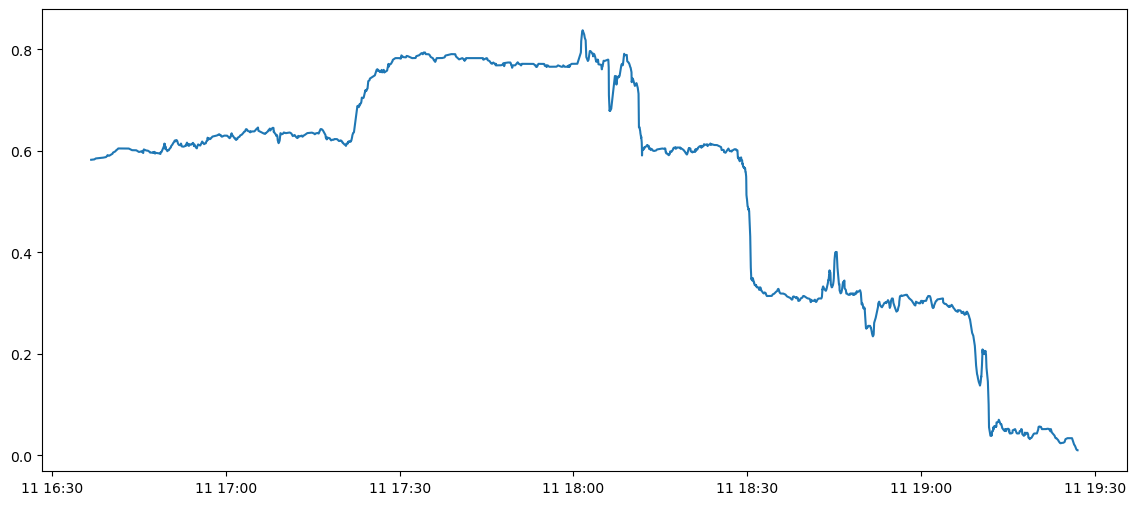

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])

In [39]:
df_score = get_score_time_series(0.8285, 0.8071, df['avg'])
print(df_score)

0.6534391049156272 0.6365608950843729
0.6534391049156272 0.6365608950843729
0-1
0-0
                    r1_gs r2_gs r1_setscore r2_setscore
2018-07-11 16:36:43     1     0           0           0
2018-07-11 16:36:44     1     0           0           0
2018-07-11 16:36:45     1     0           0           0
2018-07-11 16:36:46     1     0           0           0
2018-07-11 16:36:47     1     0           0           0
...                   ...   ...         ...         ...
2018-07-11 19:26:58     1     0           0           0
2018-07-11 19:26:59     1     0           0           0
2018-07-11 19:27:00     1     0           0           0
2018-07-11 19:27:01     1     0           0           0
2018-07-11 19:27:02     1     0           0           0

[10220 rows x 4 columns]


In [44]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
print(df_runner_1)

2018-07-11 16:36:43   2018-07-11 16:36:43
2018-07-11 16:36:44   2018-07-11 16:36:44
2018-07-11 16:36:45   2018-07-11 16:36:45
2018-07-11 16:36:46   2018-07-11 16:36:46
2018-07-11 16:36:47   2018-07-11 16:36:47
                              ...        
2018-07-11 19:27:58   2018-07-11 19:27:58
2018-07-11 19:27:59   2018-07-11 19:27:59
2018-07-11 19:28:00   2018-07-11 19:28:00
2018-07-11 19:28:01   2018-07-11 19:28:01
2018-07-11 19:28:02   2018-07-11 19:28:02
Name: back, Length: 10280, dtype: datetime64[ns]
                          back       lay    back_vol      lay_vol  \
2018-07-11 16:36:43   1.720000  1.710000  168.530000  2037.760000   
2018-07-11 16:36:44   1.720000  1.710000  168.530000  2037.760000   
2018-07-11 16:36:45   1.720000  1.710000  168.530000  2063.285714   
2018-07-11 16:36:46   1.720000  1.710000  168.530000  2097.320000   
2018-07-11 16:36:47   1.720000  1.710000  168.530000  2134.757714   
...                        ...       ...         ...          ...   
2018-0

In [45]:
df_runner_2 = best_available_df(runner_list_2, start, end)
print(df_runner_2)

2018-07-11 16:36:43   2018-07-11 16:36:43
2018-07-11 16:36:44   2018-07-11 16:36:44
2018-07-11 16:36:45   2018-07-11 16:36:45
2018-07-11 16:36:46   2018-07-11 16:36:46
2018-07-11 16:36:47   2018-07-11 16:36:47
                              ...        
2018-07-11 19:27:58   2018-07-11 19:27:58
2018-07-11 19:27:59   2018-07-11 19:27:59
2018-07-11 19:28:00   2018-07-11 19:28:00
2018-07-11 19:28:01   2018-07-11 19:28:01
2018-07-11 19:28:02   2018-07-11 19:28:02
Name: back, Length: 10280, dtype: datetime64[ns]
                         back       lay     back_vol      lay_vol  \
2018-07-11 16:36:43  2.400000  2.360000     3.000000  1487.840000   
2018-07-11 16:36:44  2.400000  2.360000     3.000000  1487.840000   
2018-07-11 16:36:45  2.400000  2.351667     3.000000  1374.644167   
2018-07-11 16:36:46  2.400000  2.340556     3.000000  1223.716389   
2018-07-11 16:36:47  2.400000  2.328551     3.000000   990.761231   
...                       ...       ...          ...          ...   
2018-0

                     ltp odds  back lay odds
2018-07-11 16:36:43  0.582314       0.581461
2018-07-11 16:36:44  0.582332       0.581461
2018-07-11 16:36:45  0.582350       0.581093
2018-07-11 16:36:46  0.582368       0.580599
2018-07-11 16:36:47  0.582387       0.580064
...                       ...            ...
2018-07-11 19:26:58  0.010017       0.034152
2018-07-11 19:26:59  0.009950       0.033927
2018-07-11 19:27:00  0.009950       0.033705
2018-07-11 19:27:01  0.009950       0.033474
2018-07-11 19:27:02  0.009950       0.033258

[10220 rows x 2 columns]


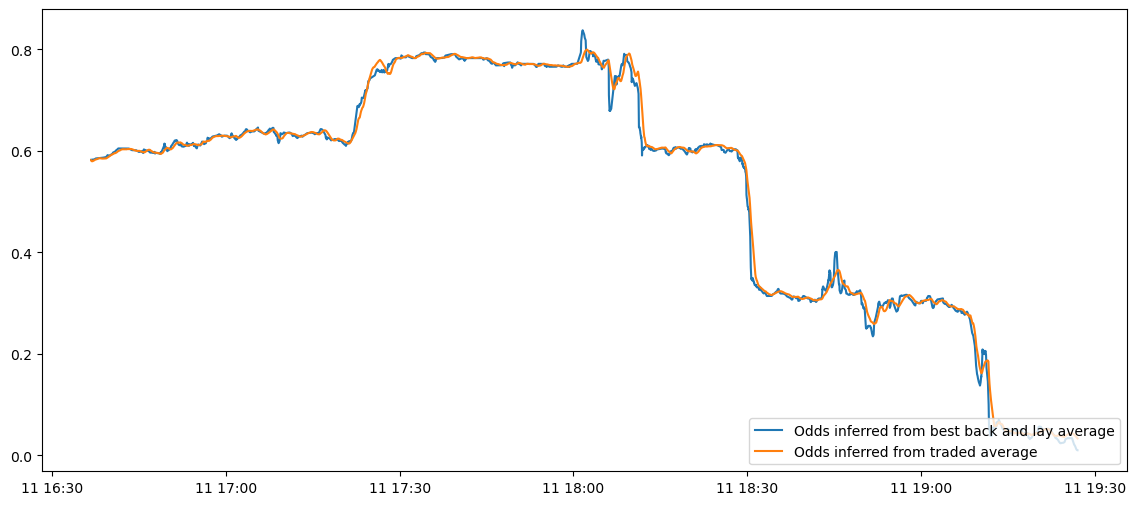

In [46]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
print(df_odds)
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

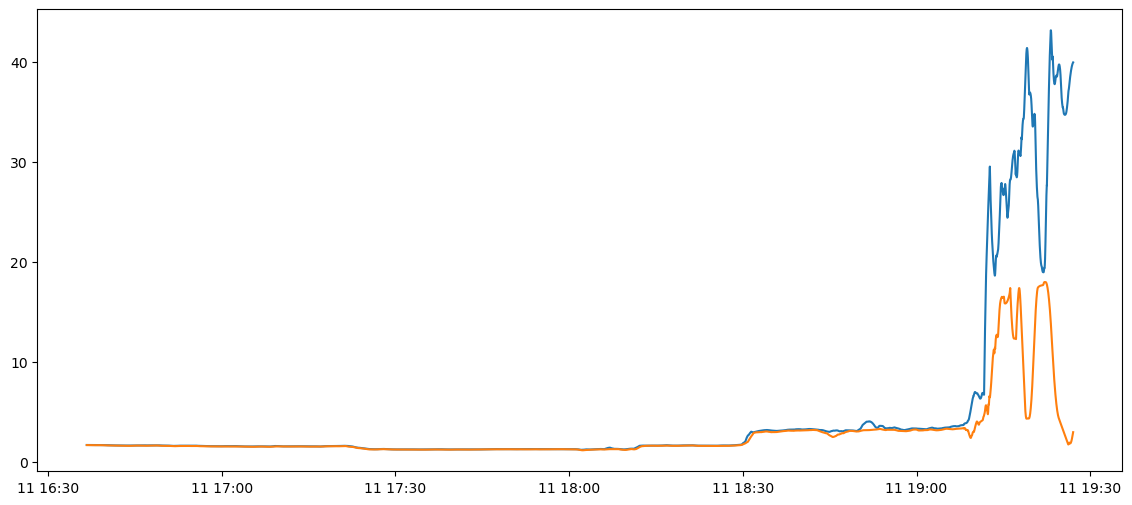

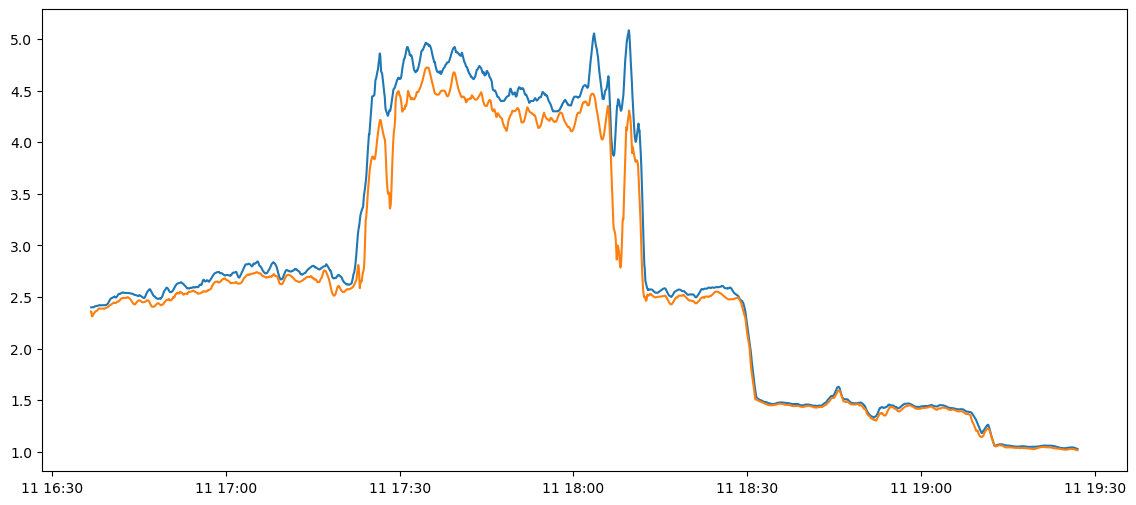

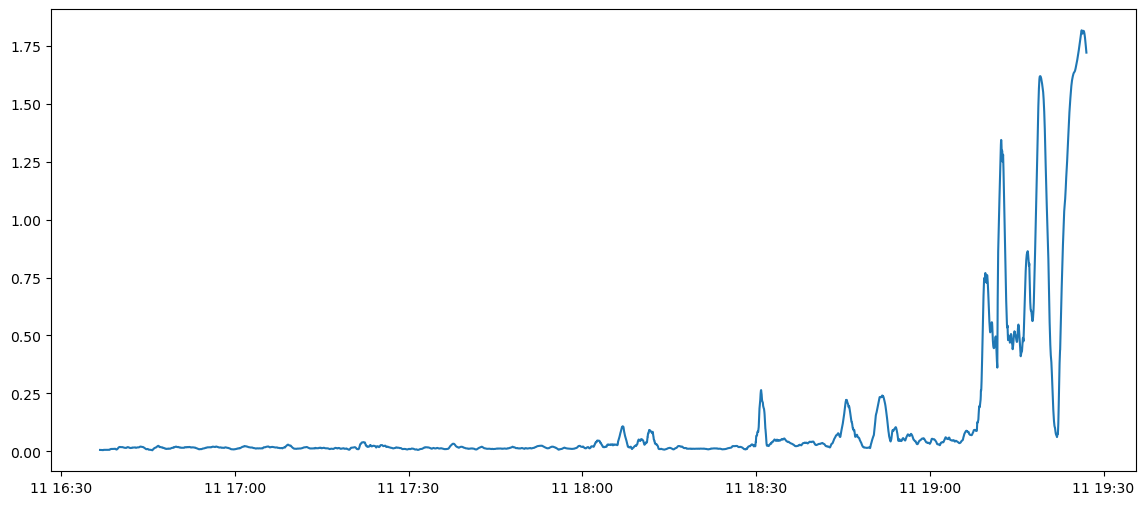

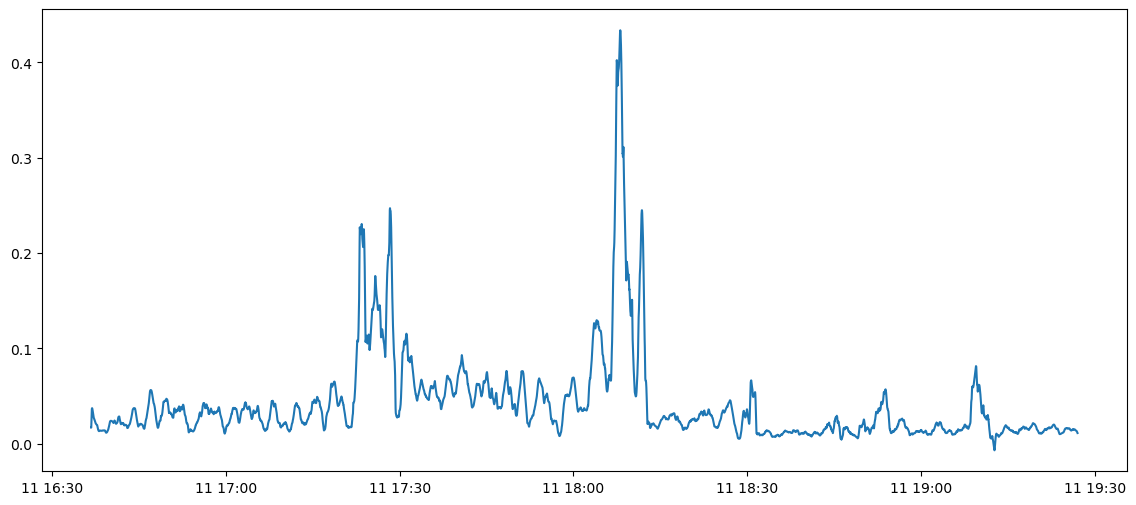

In [47]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

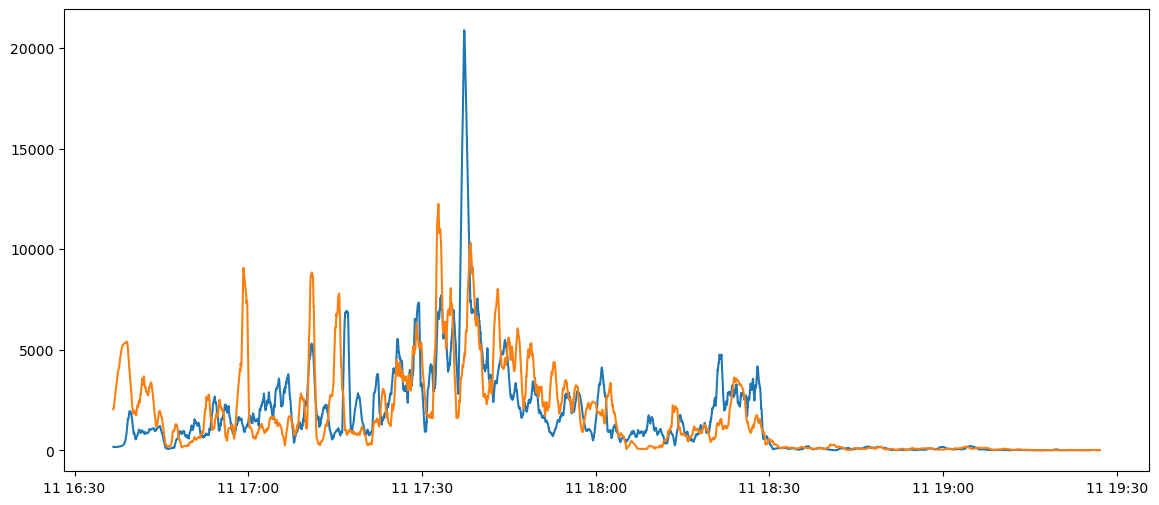

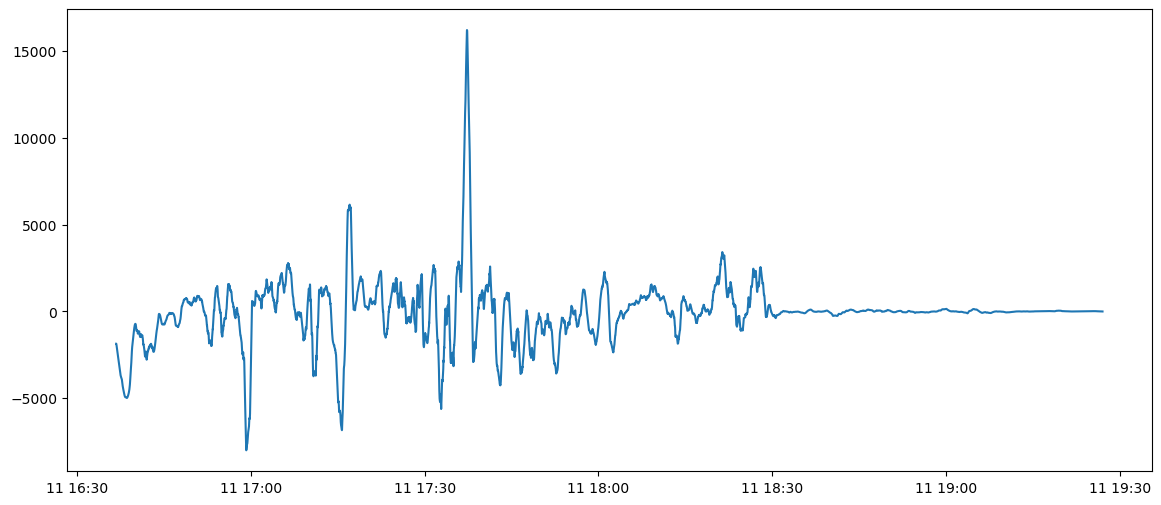

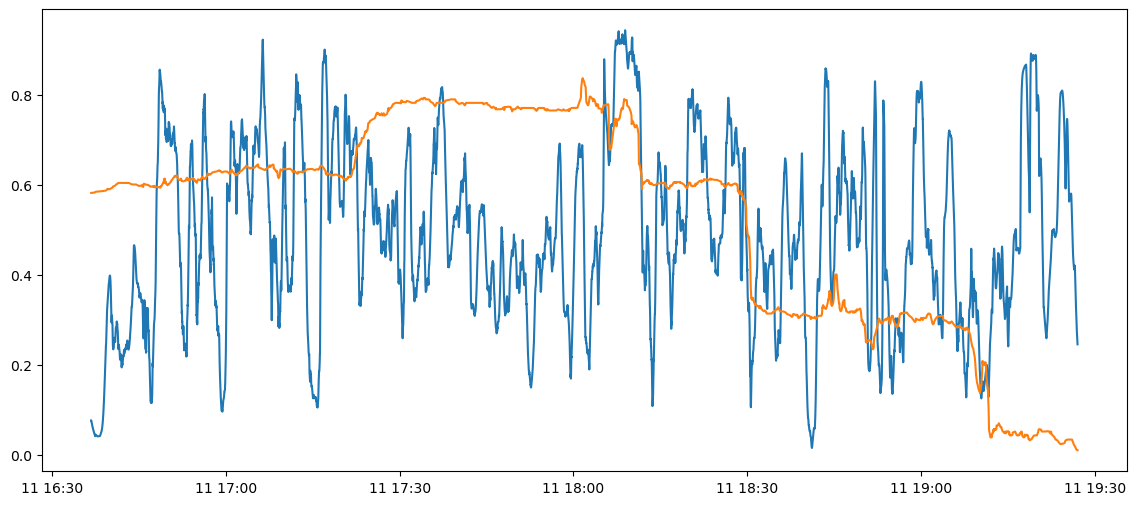

In [48]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

                     lpt odds  r1 spread    r1 pup  r2 spread    r2 pup
2018-07-11 16:36:43  0.582314   0.005831  0.076386   0.016807  0.002012
2018-07-11 16:36:44  0.582332   0.005831  0.076386   0.016807  0.002012
2018-07-11 16:36:45  0.582350   0.005831  0.075513   0.020344  0.002178
2018-07-11 16:36:46  0.582368   0.005831  0.074378   0.025079  0.002446
2018-07-11 16:36:47  0.582387   0.005831  0.073169   0.030220  0.003019
...                       ...        ...       ...        ...       ...
2018-07-11 19:26:58  0.010017   1.739036  0.261170   0.012088  0.452541
2018-07-11 19:26:59  0.009950   1.734467  0.256943   0.011863  0.454996
2018-07-11 19:27:00  0.009950   1.729862  0.252935   0.011628  0.459927
2018-07-11 19:27:01  0.009950   1.725221  0.249145   0.011334  0.466941
2018-07-11 19:27:02  0.009950   1.720543  0.245569   0.011082  0.473873

[10220 rows x 5 columns]


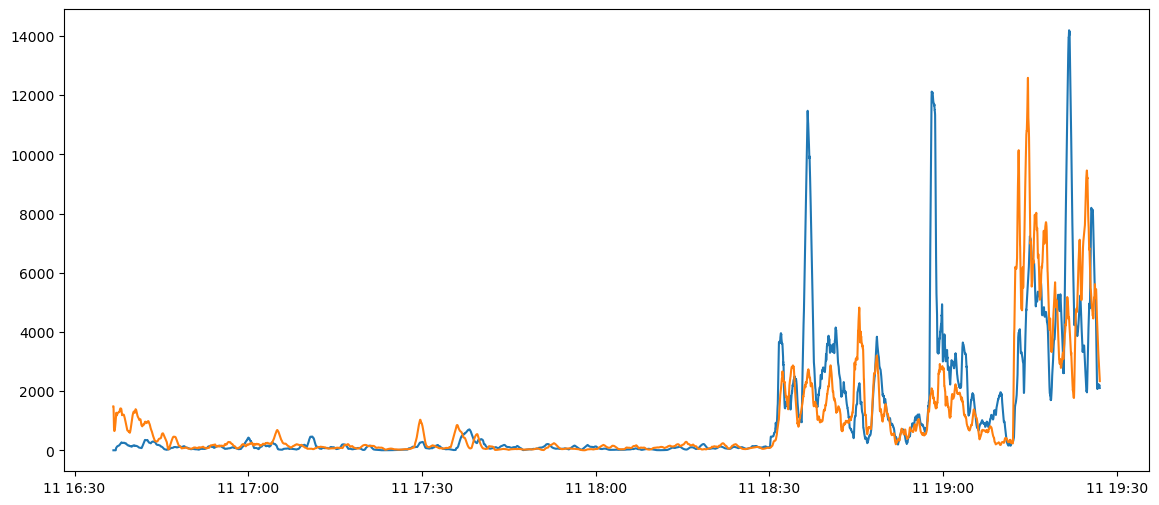

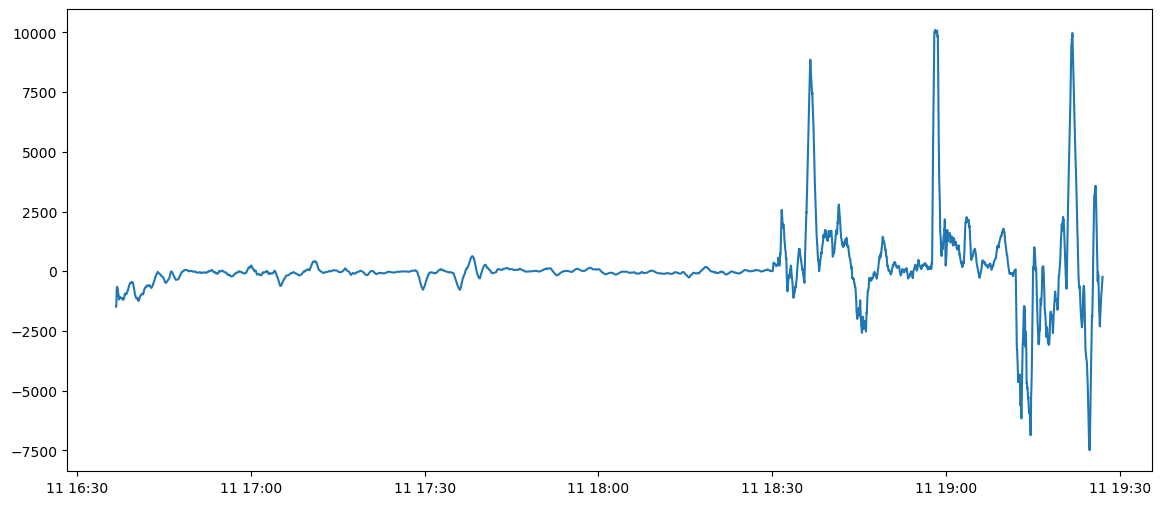

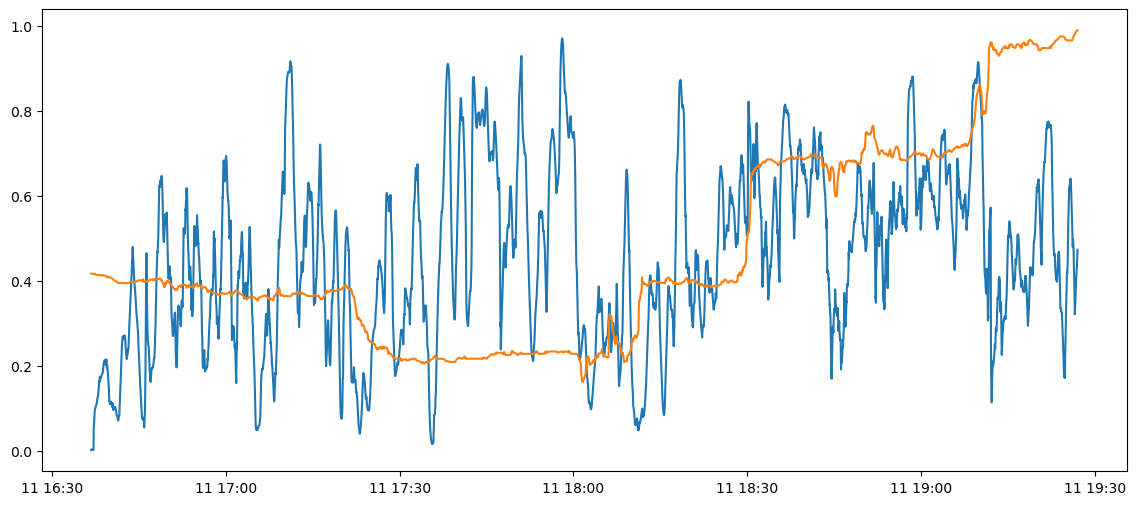

In [49]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup']}, index=df_odds.index)
print(df_total)
df_total.to_csv('Data/1.csv')